In [ ]:
pip install tensorflow

In [44]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from tensorflow import keras
from keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

import os
import matplotlib.image as mpimg

In [45]:
from zipfile import ZipFile

#extract dataset from zip file
folder_path = 'pet_images.zip'

with ZipFile(folder_path, 'r') as zip:
    zip.extractall() 

### View Information in ZipFile

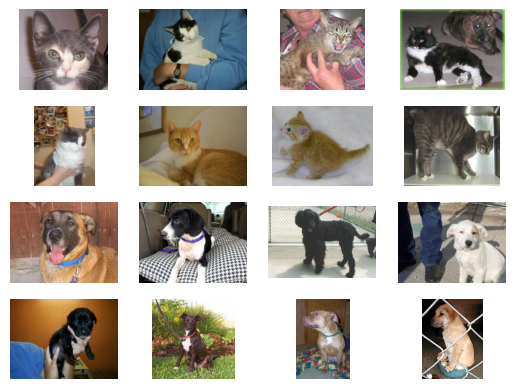

In [46]:
#access directories 
base_dir = 'kagglecatsanddogs_3367a/PetImages'
cat_dir = os.path.join(base_dir, 'Cat')
dog_dir = os.path.join(base_dir, 'Dog')
cat_dir_list = os.listdir(cat_dir)
dog_dir_list = os.listdir(dog_dir)

#access images

cat_images = [os.path.join(cat_dir, fname)
              for fname in cat_dir_list]
dog_images = [os.path.join(dog_dir, fname)
              for fname in dog_dir_list]

pic_index = 210

cat_images_to_view = cat_images[pic_index - 8: pic_index]
dog_images_to_view = dog_images[pic_index - 8: pic_index]

#show dir images

for rows, img_path in enumerate(cat_images_to_view + dog_images_to_view):
    fig = plt.subplot(4, 4, rows + 1)
    fig.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()


### Data Visualization

In [47]:
cat_df = pd.DataFrame({
    'image': cat_images,
    'label': ['cat'] * len(cat_images)
})

dog_df = pd.DataFrame({
    'image': dog_images,
    'label': ['dog'] * len(dog_images)
})

all_pets_df = pd.concat([cat_df, dog_df])

print(f'Shape of df: {all_pets_df.shape}')

#confirm they were concatenated
print(all_pets_df['label'].unique())

Shape of df: (24961, 2)
['cat' 'dog']


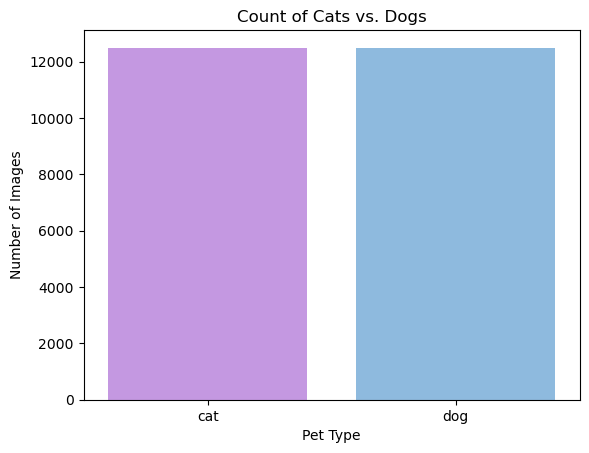

In [48]:
#visualize with seaborn

import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#c68ced', '#81bbeb']
sns.countplot(x='label', data = all_pets_df, palette = colors)

plt.title('Count of Cats vs. Dogs')
plt.xlabel('Pet Type')
plt.ylabel('Number of Images')
plt.show()

### Remove any broken image links

In [ ]:
import os
import tensorflow as tf
from PIL import Image

base_dir = 'kagglecatsanddogs_3367a/PetImages'
missing_files = []

for category in ['Cat', 'Dog']:
    folder_path = os.path.join(base_dir, category)
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        try:
            # Test 1: verify failed so do a full load
            with Image.open(file_path) as img:
                img.load()  # Force full image load
            
            # Test 2: TensorFlow decode
            raw = tf.io.read_file(file_path)
            tf.image.decode_image(raw)
            
        except Exception as e:
            print(f"Corrupted: {file_path} - {e}")
            missing_files.append(file_path)

# Delete corrupted files
for file_path in missing_files:
    os.remove(file_path)

print(f"\nRemoved {len(missing_files)} corrupted files")

Corrupted: kagglecatsanddogs_3367a/PetImages\Cat\4351.jpg - {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + row_size * abs_height) but they differ by 2 [Op:DecodeImage] name: 
Corrupted: kagglecatsanddogs_3367a/PetImages\Cat\Thumbs.db - cannot identify image file 'kagglecatsanddogs_3367a/PetImages\\Cat\\Thumbs.db'
Corrupted: kagglecatsanddogs_3367a/PetImages\Dog\11233.jpg - {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Corrupted: kagglecatsanddogs_3367a/PetImages\Dog\11912.jpg - {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Corrupted: kagglecatsanddogs_3367a/PetImages\Dog\2317.jpg - {{function_node __wrapped__DecodeImage_device_/job:l

### Split Data
- 90% train 10% test
- resize images to 200x200px
- 32 images per batch

In [ ]:
base_dir = 'kagglecatsanddogs_3367a/PetImages'

#train vs test data
train_datagen = image_dataset_from_directory(base_dir, 
                                             image_size=(200,200),
                                             subset='training',
                                             seed=1,
                                             validation_split=0.1,
                                             batch_size = 32)

test_datagen = image_dataset_from_directory(base_dir, 
                                             image_size=(200,200),
                                             subset='validation',
                                             seed=1,
                                             validation_split=0.1,
                                             batch_size = 32)

Found 24952 files belonging to 2 classes.
Using 22457 files for training.
Found 24952 files belonging to 2 classes.
Using 2495 files for validation.


### Build Models

- using binary cross-entropy, adam optimzer and accuracy
- train for 10 epochs

In [ ]:
from tensorflow.keras import layers, models

model = models.Sequential([
    # Normalize pixel values from [0,255] to [0,1]
    layers.Rescaling(1./255, input_shape=(200, 200, 3)),
    
    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    # Flatten + classify
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # prevent overfitting
    layers.Dense(1, activation='sigmoid')  # output: cat or dog
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,760,641 (33.42 MB)

 Trainable params: 8,760,641 (33.42 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(train_datagen,
          epochs=10,
          validation_data=test_datagen)

Epoch 1/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 333s 471ms/step - accuracy: 0.6600 - loss: 0.6132 - val_accuracy: 0.7527 - val_loss: 0.5001
Epoch 2/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 340s 484ms/step - accuracy: 0.7578 - loss: 0.4973 - val_accuracy: 0.7840 - val_loss: 0.4570
Epoch 3/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 330s 471ms/step - accuracy: 0.7987 - loss: 0.4349 - val_accuracy: 0.7900 - val_loss: 0.4423
Epoch 4/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 323s 460ms/step - accuracy: 0.8347 - loss: 0.3715 - val_accuracy: 0.8289 - val_loss: 0.3915
Epoch 5/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 297s 423ms/step - accuracy: 0.8659 - loss: 0.3119 - val_accuracy: 0.8273 - val_loss: 0.3982
Epoch 6/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 330s 470ms/step - accuracy: 0.8952 - loss: 0.2545 - val_accuracy: 0.8457 - val_loss: 0.4137
Epoch 7/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 322s 458ms/step - accuracy: 0.9174 - loss: 0.2020 - val_accuracy: 0.8393 - val_loss: 0.4571
Epoch 8/10
702/702 ━━━━━━━━━━━━━━━━━━━━ 307s 437ms/step - accuracy: 0.9355 -

### Observation
- After 10 epochs we have a 95% accuracy for trained data but a val_accuracy of 85% indicating the model is likely overfitting to the training data. 
- Let's try another model

### Utilizing MobileNetV2

In [64]:
from tensorflow.keras.applications import MobileNetV2

#load pretrained model without top classification layer

base_model = MobileNetV2(
    weights='imagenet',      
    include_top=False,       # Remove original classifier
    input_shape=(200, 200, 3)
)

# Freeze the model
base_model.trainable = False

# Build new model
model = models.Sequential([
    layers.Rescaling(1./127.5, offset=-1, input_shape=(200, 200, 3)),
    
    # Pre-trained feature extractor
    base_model,
    
    # Your custom classifier
    layers.GlobalAveragePooling2D(),  
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [66]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_datagen,
    validation_data = test_datagen,
    epochs = 5 #pretrained so fewer epochs are necessary
)

Epoch 1/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 263s 368ms/step - accuracy: 0.9802 - loss: 0.0584 - val_accuracy: 0.9884 - val_loss: 0.0361
Epoch 2/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 236s 336ms/step - accuracy: 0.9868 - loss: 0.0393 - val_accuracy: 0.9848 - val_loss: 0.0432
Epoch 3/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 1496s 2s/step - accuracy: 0.9892 - loss: 0.0314 - val_accuracy: 0.9896 - val_loss: 0.0355
Epoch 4/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 233s 331ms/step - accuracy: 0.9912 - loss: 0.0278 - val_accuracy: 0.9920 - val_loss: 0.0314
Epoch 5/5
702/702 ━━━━━━━━━━━━━━━━━━━━ 245s 349ms/step - accuracy: 0.9910 - loss: 0.0250 - val_accuracy: 0.9900 - val_loss: 0.0363


### Observations
- Now our training and test accuracy are both ~99% and our loss is very low
- Now lets try our model on a cat!

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Cat
None


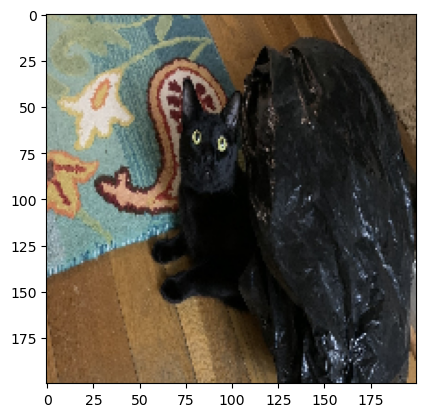

In [74]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(image_path):
    img = load_img(image_path, target_size=(200,200))
    plt.imshow(img)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)

    result= model.predict(img)
    if result > 0.5:
        print('Dog')
    else:
        print('Cat')

print(predict_image('mickey.png'))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Cat
None


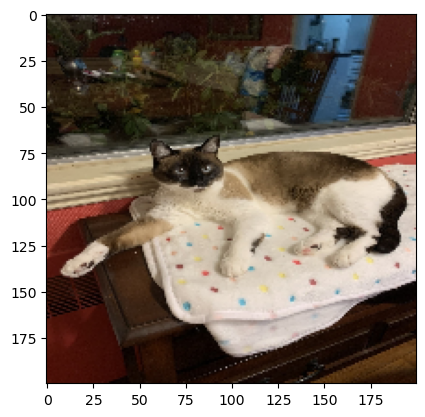

In [75]:
print(predict_image('yuzu.png'))
